In [484]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from os.path import join as pjoin
from tqdm import tqdm
import os

In [485]:
def get_first_frame(filepath = 'frame_0.png'):
    video = cv2.VideoCapture(pjoin('..','..','Test1 - alecsandr27000.mkv'))
    _, frame_0 = video.read()
    plt.imshow(frame_0)
    plt.show()
    # np.save('frame_0.npy', frame0)
    video.release()
    del video
    cv2.imwrite(filepath, frame_0)
    # plt.axis('off')  # Отключение отображения осей
    # plt.xlim(0, frame_0.shape[0])  # Определение границы оси x
    # plt.ylim(0, frame_0.shape[1])  # Определение границы оси y
    # plt.gca().invert_yaxis()  # Инвертирование оси y для совпадения с конвенцией изображений
    # plt.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=300)  # Сохранение изображения
    # plt.show()
    return frame_0

In [486]:
def low_clip_value(x, low = -np.inf):
    return max(x, low)

In [487]:
def clip_value(x, low = -np.inf, high = np.inf):
    return min(max(x, low), high)

In [488]:
def create_np_template_old(diam = 256, filename = None):
    np_template = np.ones((diam, diam))
    c = np.array(np_template.shape) // 2
    for x in range(c[1], diam):
        for y in range(int(c[0] - low_clip_value(diam**2 // 4 - (x - c[1])**2, 0)**0.5), c[0]):
            np_template[y][x] = 0
    for x in range(c[1], diam*3//4):
        for y in range(int(c[0] - low_clip_value(diam**2 // 16 - (x - c[1])**2, 0)**0.5), c[0]):
            np_template[y][x] = 1
    for x in range(0, c[1]):
        for y in range(c[0], int(c[0] + low_clip_value(diam**2 // 4 - (x - c[1])**2, 0)**0.5)):
            np_template[y][x] = 0
    for x in range(diam//4, c[1]):
        # print(diam**2 // 16 - (y - c[1])**2)
        for y in range(c[0], int(c[0] + low_clip_value(diam**2 // 16 - (x - c[1])**2, 0)**0.5)):
            np_template[y][x] = 1


    for x in range(diam//4, c[1]):
        for y in range(int(c[0] - low_clip_value(diam**2 // 16 - (x - c[1])**2, 0)**0.5), c[0]):
            np_template[y][x] = 0
    for x in range(c[1], diam*3//4):
        for y in range(c[0], int(c[0] + low_clip_value(diam**2 // 16 - (x - c[1])**2, 0)**0.5)):
            np_template[y][x] = 0

    np_template *= 255

    # plt.imshow(np_template)
    if filename:
        np.save(f'np_template_{diam}.npy', np_template)

    return np_template

In [489]:
def create_np_template(diam = 256, rot_angle = 0, filename = None):

    # Создание черно-белого изображения
    np_template = np.ones((diam, diam), dtype=np.uint8)*255

    # Определение цветов для секторов
    colors = [255, 0]  # белый, чёрный

    # Определение размеров секторов
    outer_radius = diam // 2
    inner_radius = diam // 4

    # Определение угловых градусов для секторов
    angles = np.array([0, 90, 180, 270]) - rot_angle

    # Рисование чередующихся секторов
    for i, angle in enumerate(angles):
        start_angle = angle
        end_angle = angle + 90
        color = colors[i % 2]
        cv2.ellipse(np_template, (outer_radius, outer_radius), (outer_radius, outer_radius), 0, start_angle, end_angle, color, -1)

    # Рисование внутренних секторов
    for i, angle in enumerate(angles):
        start_angle = angle
        end_angle = angle + 90
        color = colors[(i + 1) % 2]
        cv2.ellipse(np_template, (outer_radius, outer_radius), (inner_radius, inner_radius), 0, start_angle, end_angle, color, -1)

    # # Отображение изображения
    # cv2.imshow('np_template', np_template)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    # Преобразование в черно-белую картинку-массив numpy
    return np.array(np_template, dtype=np.uint8)

In [490]:
def calc_diff(a, b, mask = None, reduction='MEAN'):
    if mask:
        if reduction == 'MEAN':
            return (((a - b)**2)*mask).sum() / mask.sum()
        else:#if reduction == 'SUM':
            return (((a - b)**2)*mask).sum()
    else:
        if reduction == 'MEAN':
            return ((a - b)**2).mean()
        else:#if reduction == 'SUM':
            return ((a - b)**2).sum()

In [491]:
def fill_out_circle(arr):
    np_arr = 255 - np.array(arr)
    radius = np_arr.shape[0] // 2
    cv2.ellipse(np_arr, (radius, radius), (radius, radius), 0, 0, 360, 0, -1)
    return arr + np_arr

In [492]:
image_name = 'frame_0.png'
images_dir = 'images'
image_path = pjoin(images_dir, image_name)

In [493]:
if not os.path.exists(images_dir):
    os.makedirs(images_dir)
if not os.path.exists(image_path):
    get_first_frame(image_path)

In [494]:
# Список для хранения координат кликов
click_coordinates = []

In [495]:
# Загрузка изображения
image = cv2.imread(image_path)

image_copy = np.copy(image)

In [496]:
# Функция обработки событий мыши
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:  # Если была нажата левая кнопка мыши
        global click_coordinates
        click_coordinates.append((x, y))  # Добавляем координаты клика в список
        cv2.circle(image_copy, (x, y), 3, (0, 255, 0), -1)  # Рисуем круг на месте клика

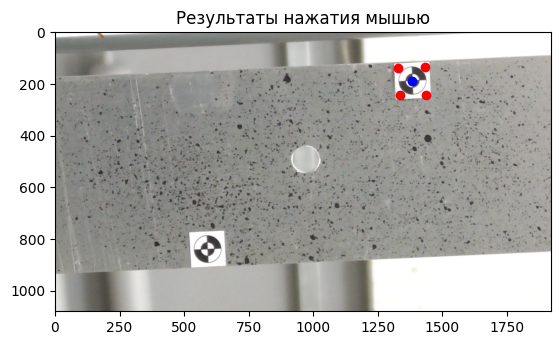

In [497]:
click_coordinates = []

# Загрузка изображения
image = cv2.imread(image_path)

image_copy = np.copy(image)

# Создание окна для отображения изображения
cv2.namedWindow('Image')

# Установка функции обратного вызова для событий мыши
cv2.setMouseCallback('Image', mouse_callback)

while True:
    # Отображение изображения
    cv2.imshow('Image', image_copy)

    # Ожидание нажатия клавиши "Esc" для выхода
    if cv2.waitKey(1) == 27 or cv2.waitKey(1) == 13:
        break

# print(click_coordinates)

click_coordinates = np.array(click_coordinates)
center = click_coordinates.mean(axis=0)

# print(center)

# Отображение мест кликов
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
for coordinate in click_coordinates:
    plt.plot(coordinate[0], coordinate[1], 'ro')

plt.plot(center[0], center[1], 'bo')
plt.title('Результаты нажатия мышью')
plt.show()
plt.show()


# Закрытие окна
cv2.destroyAllWindows()

In [498]:
click_coordinates = np.array(click_coordinates)
rad = int(max(((click_coordinates - center)**2).sum(axis=1)**0.5))
center = center.astype(int)

(1080, 1920, 3)


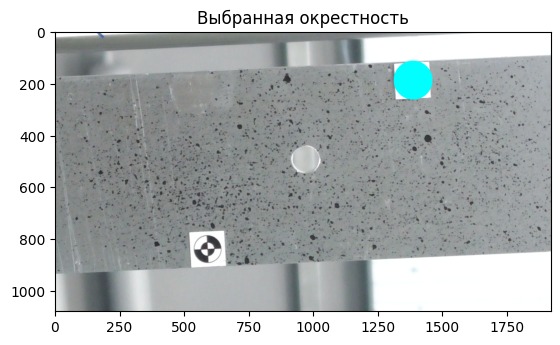

In [499]:
image_copy = image.copy()
print(image_copy.shape)
# cv2.namedWindow('Image')
cv2.circle(image_copy, center, rad, (0, 255, 255), -1)
plt.imshow(image_copy)
plt.title('Выбранная окрестность')
plt.show()
# cv2.imshow('Image', image_copy)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [500]:
image_copy = image.copy()

In [501]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [502]:
mark_part = image_gray[center[1] - rad:center[1] + rad, center[0] - rad:center[0] + rad]

In [503]:
# # mask = np.zeros_like(mark_part)
# diam = mark_part.shape[0]
# for y in range(0, diam):
#     _pad = int(diam//2  - low_clip_value(diam**2//4 - (y-diam//2)**2, 0)**0.5)
#     for x in range(0, _pad):
#         mark_part[y][x] = 255
#     for y in range(diam - _pad, diam):
#         mark_part[y][x] = 255


In [504]:
label_pos_x, label_pos_y = center[0] - rad, center[1] - rad

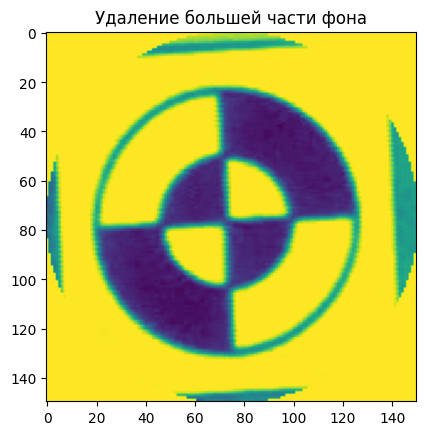

In [505]:
mark_part = fill_out_circle(mark_part)
plt.imshow(mark_part)
plt.title('Удаление большей части фона')
plt.show()

In [506]:
ret, thresh = cv2.threshold(mark_part, 170, 255, 0)
contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [507]:
thresh = 255 - thresh

In [508]:
contours_image, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

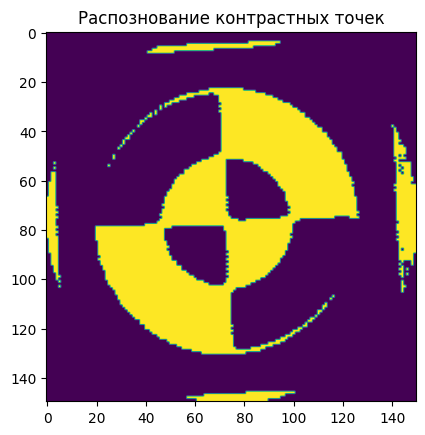

In [509]:
plt.imshow(thresh)
plt.title('Распознование контрастных точек')
plt.show()

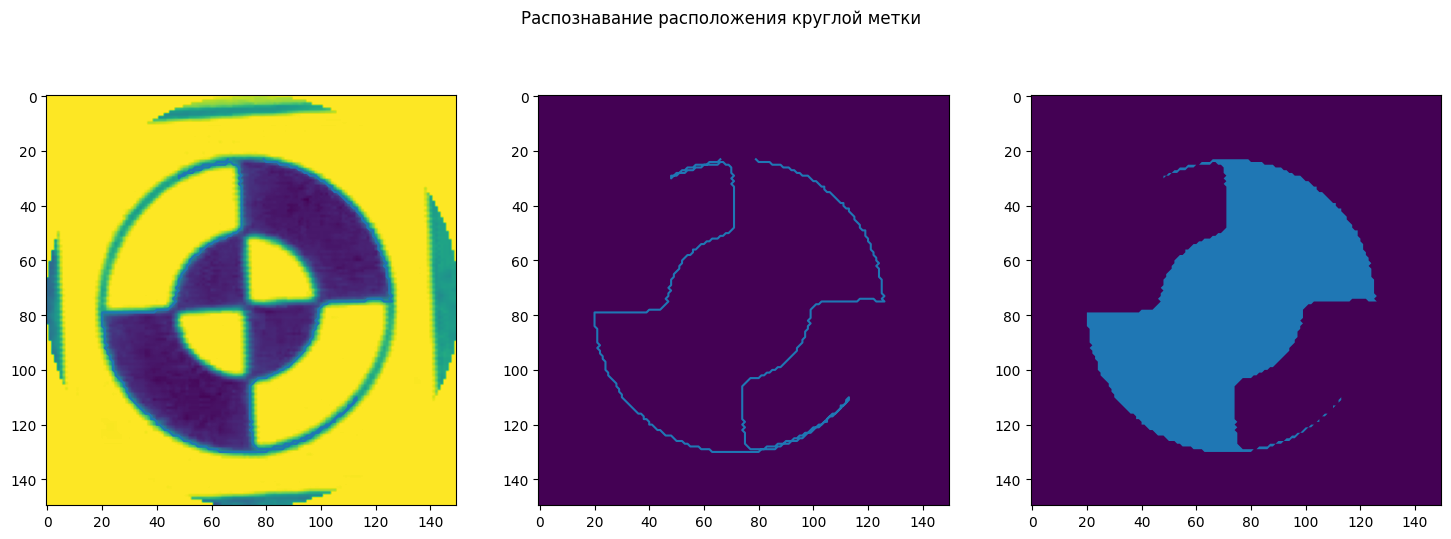

In [510]:
fig, ax = plt.subplots(1,3, figsize=(18,6))
# ax[0].imshow(mark_part)
ax[0].imshow(mark_part)
ax[1].imshow(np.zeros_like(mark_part))
ax[2].imshow(np.zeros_like(mark_part))
part_area = mark_part.shape[0]*mark_part.shape[1]
min_area_lim = part_area / 12
max_area_lim = part_area * 0.9
best_cntr = contours_image[0]
best_cntr_area = cv2.contourArea(best_cntr)
for cntr in contours_image:
    area = cv2.contourArea(cntr)
    if area > min_area_lim and area < max_area_lim:
        if (area > best_cntr_area):
            best_cntr = cntr
            best_cntr_area = area
        cntr_np = np.array(cntr).reshape(-1, 2)
        ax[0].plot(cntr_np[:,0], cntr_np[:,1])
        ax[1].plot(cntr_np[:,0], cntr_np[:,1])
        ax[2].fill(cntr_np[:,0], cntr_np[:,1])
fig.suptitle('Распознавание расположения круглой метки')
plt.show()

In [511]:
x,y,w,h = cv2.boundingRect(best_cntr)
wh_mean = (w + h) // 2
dx = (w - wh_mean) // 2
dy = (h - wh_mean) // 2

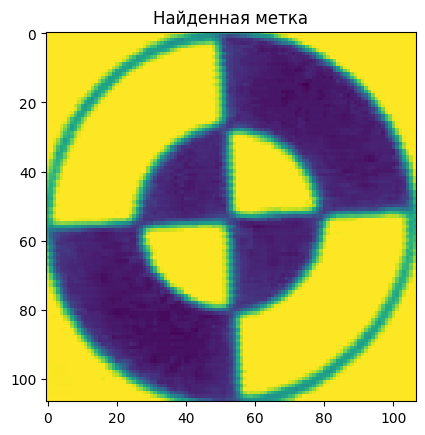

In [512]:
plt.imshow(mark_part[y + dy:y + dy + wh_mean, x + dx:x + dx + wh_mean])
plt.title('Найденная метка')
plt.show()

In [513]:
label_pos_x += x + dx
label_pos_y += y + dy

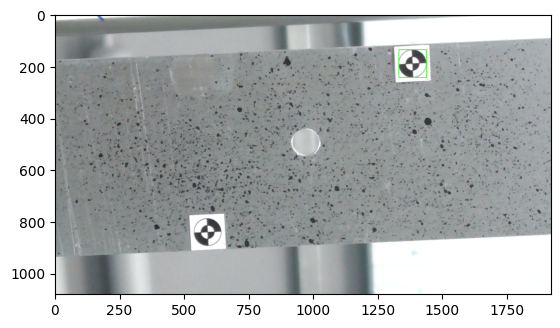

In [514]:
image_copy = image.copy()
cv2.rectangle(image_copy, (label_pos_x, label_pos_y), (label_pos_x + wh_mean, label_pos_y + wh_mean), (36,255,12), 2)
plt.imshow(image_copy)
# cv2.imshow('Image', image_copy)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [515]:
detected_template = image_gray[label_pos_y:label_pos_y + wh_mean,label_pos_x:label_pos_x + wh_mean]
ret, thresh = cv2.threshold(detected_template, 170, 255, 0)

In [516]:
for grad in range(0,5):
    print(f'{grad} : {calc_diff(thresh,create_np_template(wh_mean,grad))}')

0 : 0.05747226832037733
1 : 0.049261944274609136
2 : 0.046991003581098784
3 : 0.04891256878329985
4 : 0.054939296008385013


In [517]:
def golden_section_search(func, min_val, max_val, eps, *args):
    golden_ratio = (1 + 5 ** 0.5) / 2  # Золотое сечение

    a = min_val
    b = max_val

    while abs(b - a) > eps:
        x1 = b - (b - a) / golden_ratio
        x2 = a + (b - a) / golden_ratio

        f1 = func(x1, *args)
        f2 = func(x2, *args)

        if f1 < f2:
            b = x2
        else:
            a = x1

    return (a + b) / 2

In [518]:
# Задаем интервал значений и точность
min_val = 0
mean_val = 90
max_val = 180
eps = 0.1

In [519]:
func = lambda grad_val, thr: calc_diff(thr,create_np_template(diam=wh_mean,rot_angle=grad_val))

In [520]:
# Вызываем быстрый поиск для функции func
result_1 = golden_section_search(func, min_val, mean_val, eps, thresh)
result_2 = golden_section_search(func, mean_val, max_val, eps, thresh)

In [521]:
print("Значение угла, при котором достигается минимум ошибки в первой половине:", result_1)
val_1 = func(result_1, thresh)
print("Минимальное значение ошибки:", val_1)

print("Значение угла, при котором достигается минимум ошибки во второй половине:", result_2)
val_2 = func(result_2, thresh)
print("Минимальное значение ошибки:", val_2)

result = result_1 if val_1 <= val_2 else result_2
val = min(val_1, val_2)

print('______________________')

print("Значение угла, при котором достигается минимум ошибки:", result)
print("Минимальное значение ошибки:", val)

Значение угла, при котором достигается минимум ошибки в первой половине: 2.507764050037855
Минимальное значение ошибки: 0.04891256878329985
Значение угла, при котором достигается минимум ошибки во второй половине: 179.9670088153864
Минимальное значение ошибки: 0.05834570704865054
______________________
Значение угла, при котором достигается минимум ошибки: 2.507764050037855
Минимальное значение ошибки: 0.04891256878329985


In [522]:
most_acc_template = create_np_template(diam=wh_mean,rot_angle=result)

In [527]:
image_copy = image.copy()

In [528]:
image_copy[label_pos_y:label_pos_y + wh_mean,label_pos_x:label_pos_x + wh_mean, 0] = 255
image_copy[label_pos_y:label_pos_y + wh_mean,label_pos_x:label_pos_x + wh_mean, 1] = most_acc_template
image_copy[label_pos_y:label_pos_y + wh_mean,label_pos_x:label_pos_x + wh_mean, 2] = 255
cv2.imshow('Result',image_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [529]:
print(f'Координаты метки: ({label_pos_y},{label_pos_x})')
print(f'Угол поворота метки: {result}')

Координаты метки: (137,1328)
Угол поворота метки: 2.507764050037855


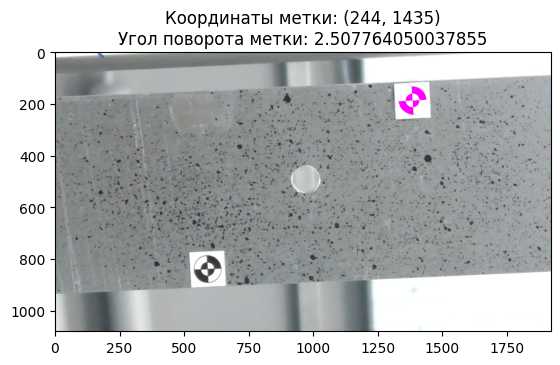

In [530]:
plt.imshow(image_copy)
plt.title(f'Координаты метки: ({label_pos_y + wh_mean}, {label_pos_x + wh_mean})\nУгол поворота метки: {result}')
plt.show()